In [1]:
%matplotlib inline
%time from hikyuu.interactive import *
iodog.open()

2022-08-22 11:14:39,044 [INFO] NumExpr defaulting to 4 threads. [numexpr.utils::_init_num_threads]


std::cout are redirected to python::stdout
std::cerr are redirected to python::stderr
2022-08-22 11:14:40.025 [HKU-I] - Using SQLITE3 BaseInfoDriver (BaseInfoDriver.cpp:58)
2022-08-22 11:14:40.055 [HKU-I] - Loading market information... (StockManager.cpp:497)
2022-08-22 11:14:40.056 [HKU-I] - Loading stock type information... (StockManager.cpp:510)
2022-08-22 11:14:40.056 [HKU-I] - Loading stock information... (StockManager.cpp:424)
2022-08-22 11:14:40.136 [HKU-I] - Loading stock weight... (StockManager.cpp:527)
2022-08-22 11:14:41.620 [HKU-I] - Loading KData... (StockManager.cpp:139)
2022-08-22 11:14:41.708 [HKU-I] - Preloading all day kdata to buffer! (StockManager.cpp:162)
2022-08-22 11:14:41.734 [HKU-I] - 0.11s Loaded Data. (StockManager.cpp:150)
Wall time: 3.69 s


In [2]:
def getNextWeekDate(week):
    """获取指定日期的下一周周一日期"""
    from datetime import timedelta
    py_week = week.datetime()
    next_week_start = py_week + timedelta(days = 7 - py_week.weekday())
    return Datetime(next_week_start)

In [13]:
 import pyspark

In [3]:
def DEMO_SG(self):
    """
    买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入
    卖出信号：日线级别 跌破 20日均线
    
    参数：
    week_macd_n1：周线dif窗口
    week_macd_n2: 周线dea窗口
    week_macd_n3: 周线macd平滑窗口
    day_n: 日均线窗口
    """
    k = self.to
    if (len(k) == 0):
        return
    
    stk = k.get_stock()
    
    #-----------------------------
    #计算日线级别的卖出信号        
    #-----------------------------
    day_c = CLOSE(k)
    day_ma = MA(day_c, self.get_param("day_n"))
    day_x = day_c < day_ma  #收盘价小于均线
    for i in range(day_x.discard, len(day_x)):
        if day_x[i] >= 1.0:
            self._add_sell_signal(k[i].datetime)

    #-----------------------------
    #计算周线级别的买入信号        
    #-----------------------------
    week_q = Query(k[0].datetime, k[-1].datetime.next_day(), ktype=Query.WEEK)
    week_k = k.get_stock().get_kdata(week_q)
    
    n1 = self.get_param("week_macd_n1")
    n2 = self.get_param("week_macd_n2")
    n3 = self.get_param("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.get_result(0)
    slow = m.get_result(1)
    
    discard = m.discard if m.discard > 1 else 1
    for i in range(discard, len(m)):
        if (fast[i-1] < slow[i-1] and fast[i] > slow[i]):
            #当周计算的结果，只能作为下周一的信号
            self._add_buy_signal(week_k[i].datetime.next_week())
         

In [4]:
class DEMO_MM(MoneyManagerBase):
    """
    买入：30% （不明确，暂且当做当前现金的30%）
    卖出：已持仓股票数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        
    def _reset(self):
        pass
    
    def _clone(self):
        return DEMO_MM()
        
    def _get_buy_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        cash = tm.current_cash
        
        #可以不用考虑最小交易单位的问题，已经自动处理
        #num = int((cash * 0.3 // price // stk.atom) * stk.atom)
        return int(cash*0.3/price) #返回类型必须是int
    
    def _get_sell_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        position = tm.get_position(datetime, stk)
        total_num = position.number
        num = int(total_num * 0.5)
        return num if num >= 100 else 0

In [5]:
#账户参数
init_cash = 500000 #账户初始资金
init_date = Datetime('2021-7-20') #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9
day_n = 5

#选定标的，及测试区间
stk = sm['SH603527']
#start_date = Datetime('2021-04-21')  #如果是同一级别K线，可以使用索引号，使用了不同级别的K线数据，建议还是使用日期作为参数
start_date = init_date

end_date = Datetime()

In [6]:
#创建账户
my_tm = crtTM(date=init_date, init_cash = init_cash, cost_func=TC_FixedA())

#创建系统实例
my_sys = SYS_Simple()

#绑定账户
my_sys.tm = my_tm

#绑定信号指示器
my_sys.sg = crtSG(DEMO_SG, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3, 'day_n': day_n}, 
                'DEMO_SG') 
my_sys.sg.set_param('alternate', False)

#绑定资金管理策略
my_sys.mm = DEMO_MM()

In [7]:
iodog.close()
q = Query(start_date, end_date, ktype=Query.DAY)
my_sys.run(stk, q)

#将交易记录及持仓情况，保存在临时目录，可用Excel查看
#临时目录一般设置在数据所在目录下的 tmp 子目录
#如果打开了excel记录，再次运行系统前，记得先关闭excel文件，否则新的结果没法保存
my_tm.tocsv(sm.tmpdir())

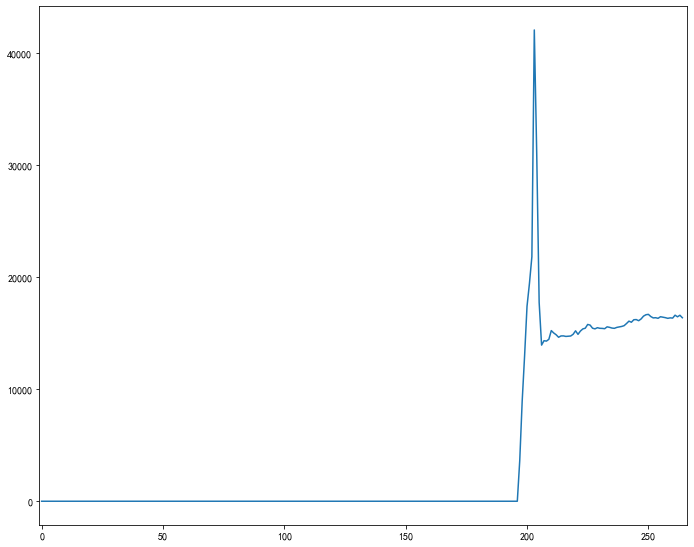

In [8]:
#绘制资金收益曲线（净收益）
x = my_tm.get_profit_curve(stk.get_datetime_list(q), Query.DAY)
#x = my_tm.getFundsCurve(stk.getDatetimeList(q), KQuery.DAY) #总资产曲线
x = PRICELIST(x)
x.plot()

In [9]:
#回测统计
per = Performance()
print(per.report(my_tm, Datetime.now()))

帐户初始金额: 500000.00
累计投入本金: 500000.00
累计投入资产: 0.00
累计借入现金: 0.00
累计借入资产: 0.00
累计红利: 3400.00
现金余额: 513733.14
未平仓头寸净值: 2637.39
当前总资产: 516370.53
已平仓交易总成本: 0.00
已平仓净利润总额: 0.00
单笔交易最大占用现金比例%: 29.98
交易平均占用现金比例%: 29.98
已平仓帐户收益率%: 0.00
帐户年复合收益率%: 12.89
帐户平均年收益率%: 12.32
赢利交易赢利总额: 0.00
亏损交易亏损总额: 0.00
已平仓交易总数: 0.00
赢利交易数: 0.00
亏损交易数: 0.00
赢利交易比例%: 0.00
赢利期望值: 0.00
赢利交易平均赢利: 0.00
亏损交易平均亏损: 0.00
平均赢利/平均亏损比例: 0.00
净赢利/亏损比例: 0.00
最大单笔赢利: 0.00
最大单笔亏损: 0.00
赢利交易平均持仓时间: 0.00
赢利交易最大持仓时间: 0.00
亏损交易平均持仓时间: 0.00
亏损交易最大持仓时间: 0.00
空仓总时间: 98.00
空仓时间/总时间%: 100.00
平均空仓时间: 98.00
最长空仓时间: 97.00
最大连续赢利笔数: 0.00
最大连续亏损笔数: 0.00
最大连续赢利金额: 0.00
最大连续亏损金额: 0.00
R乘数期望值: 0.00
交易机会频率/年: 0.00
年度期望R乘数: 0.00
赢利交易平均R乘数: 0.00
亏损交易平均R乘数: 0.00
最大单笔赢利R乘数: 0.00
最大单笔亏损R乘数: 0.00
最大连续赢利R乘数: 0.00
最大连续亏损R乘数: 0.00



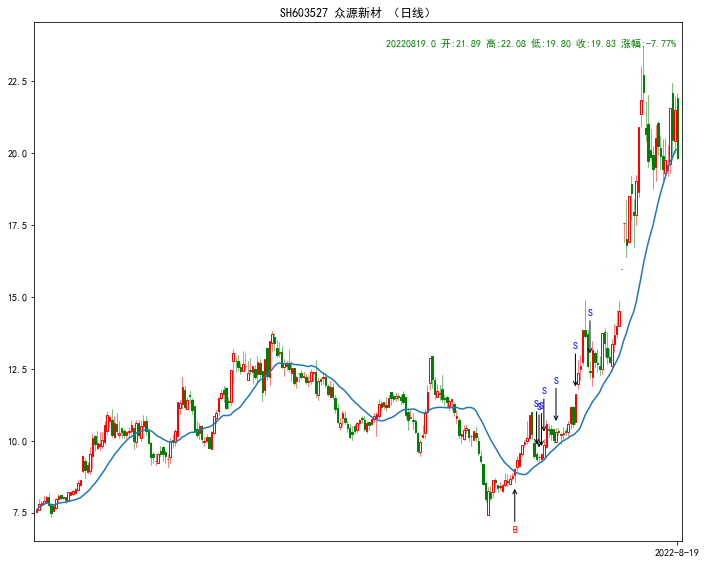

In [10]:
import warnings
warnings.filterwarnings('ignore')
my_sys.plot()
MA(CLOSE(my_sys.to), 20).plot(new=False)

In [11]:
import pandas as pd
def calTotal(blk, q):
    per = Performance()
    s_name = []
    s_code = []
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        s_name.append(stk.name)
        s_code.append(stk.market_code)
        x.append(per["当前总资产"])
    return pd.DataFrame({'代码': s_code, '股票': s_name, '当前总资产': x})

%time data = calTotal(blocka, q)

Wall time: 17.1 s


In [12]:

pd.set_option('display.max_colwidth', None)
data.sort_values(['当前总资产'],ascending = False, inplace=True)
data

,代码,股票,当前总资产
1753,SH600860,京城股份,709865.05
1234,SH605333,沪光股份,644704.10
3460,SZ002885,京泉华,626050.91
316,SH603260,合盛硅业,623436.28
2978,SZ000795,英洛华,611823.82
...,...,...,...
2475,SH605128,上海沿浦,479713.54
2358,SZ002590,万安科技,478973.65
2446,SH603997,继峰股份,478116.15
3630,SZ300338,ST开元,473907.82
